In [16]:
import requests

import os
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [17]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Example

In [18]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection 

model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
# Check for cats and remote controls
# VERY important: text queries need to be lowercased + end with a dot
text = "a remote control. a cat."

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)


In [19]:
results

[{'scores': tensor([0.4018, 0.4400, 0.4280], device='cuda:0'),
  'labels': ['a cat', 'a remote control', 'a cat'],
  'boxes': tensor([[346.2125,  22.1866, 637.4597, 374.6665],
          [ 38.3567,  70.1103, 176.6912, 117.9141],
          [ 10.1982,  52.4852, 316.9336, 472.7597]], device='cuda:0')}]

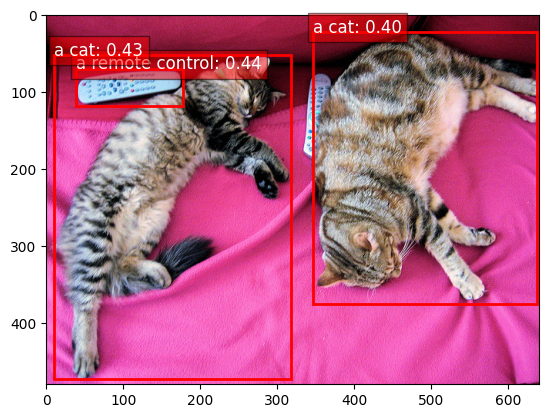

In [20]:
# Plot the image and add the bounding boxes
fig, ax = plt.subplots(1)
ax.imshow(image)

for result in results:
    boxes = result['boxes'].cpu()  # Move boxes tensor to CPU
    scores = result['scores'].cpu()  # Move scores tensor to CPU
    labels = result['labels']

    for box, score, label in zip(boxes, scores, labels):
        if score >= 0.4:  # Filter out boxes with low confidence
            x, y, w, h = box
            rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, f'{label}: {score:.2f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

plt.show()

## Apply

In [21]:
Image.MAX_IMAGE_PIXELS = None

model_id = "IDEA-Research/grounding-dino-base"
#model_id = "IDEA-Research/grounding-dino-tiny"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(DEVICE)


dataset_folder = '/blue/hulcr/eric.kuo/test_dataset/train/images'
output_folder = '/blue/hulcr/eric.kuo/test_dataset/train/labels'

text_queries = 'a bug.'

In [22]:
os.makedirs(output_folder, exist_ok=True)

TESTING

In [23]:
# Function to convert bounding boxes to YOLO format
def convert_to_yolo_format(image_size, boxes):
    yolo_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        x_center = (x_min + x_max) / 2.0
        y_center = (y_min + y_max) / 2.0

        # Normalize coordinates
        x_center /= image_size[0]
        y_center /= image_size[1]
        width /= image_size[0]
        height /= image_size[1]

        yolo_boxes.append(f"0 {x_center} {y_center} {width} {height}")  # class index 0 for beetles

    return yolo_boxes

In [24]:
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif')):  # Add other image extensions if needed
            image_path = os.path.join(root, file)
            output_subfolder = os.path.join(output_folder, os.path.relpath(root, dataset_folder))
            os.makedirs(output_subfolder, exist_ok=True)
            
            # Load image
            image = Image.open(image_path).convert("RGB")
            print(f"Processing {image_path} with size {image.size} and mode {image.mode}")
            
            # Process image with Grounding DINO
            inputs = processor(images=image, text=text_queries, return_tensors="pt").to(DEVICE)
            
            with torch.no_grad():
                outputs = model(**inputs)
            
            results = processor.post_process_grounded_object_detection(
                outputs,
                inputs.input_ids,
                box_threshold=0.4,
                text_threshold=0.1,
                target_sizes=[image.size[::-1]]
            )
            
            # Convert and save annotations in YOLO format
            image_size = image.size
            yolo_annotations = convert_to_yolo_format(image_size, results[0]['boxes'])
            
            # Save annotations to a txt file
            output_txt_path = os.path.join(output_subfolder, os.path.splitext(file)[0] + ".txt")
            with open(output_txt_path, 'w') as f:
                for annotation in yolo_annotations:
                    f.write(annotation + '\n')

Processing /blue/hulcr/eric.kuo/test_dataset/train/images/057d261dc1901954bb9976d08d93649a.png with size (1536, 2048) and mode RGB
Processing /blue/hulcr/eric.kuo/test_dataset/train/images/048e19b79e340a5d5681d19623dc6f8a.png with size (6000, 4000) and mode RGB
Processing /blue/hulcr/eric.kuo/test_dataset/train/images/01a77bfb9d348c8eb8c2e49d35d2c186.png with size (1555, 906) and mode RGB
Processing /blue/hulcr/eric.kuo/test_dataset/train/images/0218d8b359a45b6807cbdb7ce6c439ac.png with size (6000, 4000) and mode RGB
Processing /blue/hulcr/eric.kuo/test_dataset/train/images/0aff3119b766c7ec7a7b1c810e1ee0bf.png with size (713, 709) and mode RGB
Processing /blue/hulcr/eric.kuo/test_dataset/train/images/08e26a3ba96706ee62eef3f4683c6a93.png with size (3107, 2282) and mode RGB
Processing /blue/hulcr/eric.kuo/test_dataset/train/images/03c246543739a23465081e205529fe80.png with size (6000, 4000) and mode RGB
Processing /blue/hulcr/eric.kuo/test_dataset/train/images/07973cbe193e0795249ddd9cd703

## Check annotations

In [25]:
def load_yolo_annotations(file_path):
    """Load YOLO format annotations from a text file."""
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            annotations.append((class_id, x_center, y_center, width, height))
    return annotations

In [26]:
def draw_bounding_boxes(image, annotations):
    """Draw bounding boxes on the image using the provided annotations."""
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    image_width, image_height = image.size

    for annotation in annotations:
        class_id, x_center, y_center, width, height = annotation
        x_center *= image_width
        y_center *= image_height
        width *= image_width
        height *= image_height

        x_min = x_center - width / 2
        y_min = y_center - height / 2

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'Class {int(class_id)}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

In [27]:
def process_directory(image_folder, annotation_folder):
    """Process the directory and display images with bounding boxes."""
    for root, dirs, files in os.walk(image_folder):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif')):
                image_path = os.path.join(root, file)
                annotation_path = os.path.join(annotation_folder, os.path.relpath(root, image_folder), os.path.splitext(file)[0] + ".txt")

                if os.path.exists(annotation_path):
                    image = Image.open(image_path)
                    annotations = load_yolo_annotations(annotation_path)
                    draw_bounding_boxes(image, annotations)

In [28]:
import random

dataset_folder = '/blue/hulcr/eric.kuo/test_dataset/train/images'
annotations_folder = '/blue/hulcr/eric.kuo/test_dataset/train/labels'
image_paths = []


for root, dirs, files in os.walk(dataset_folder):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif')):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)

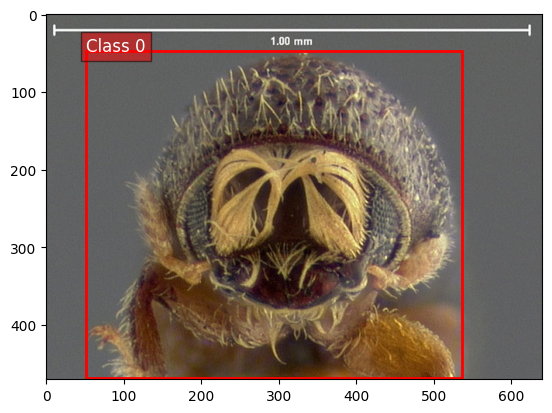

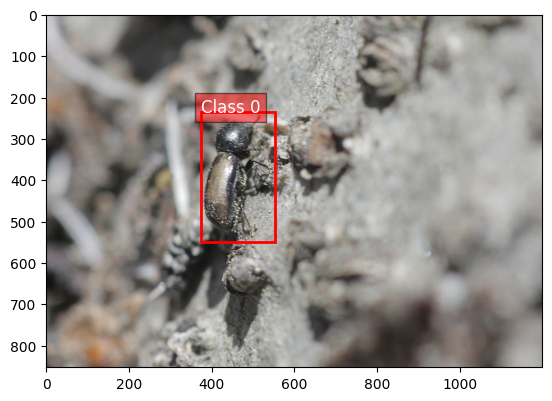

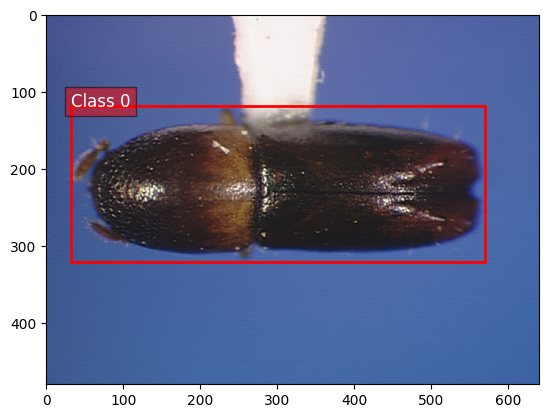

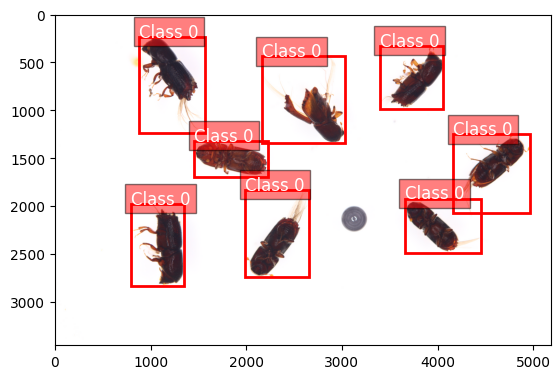

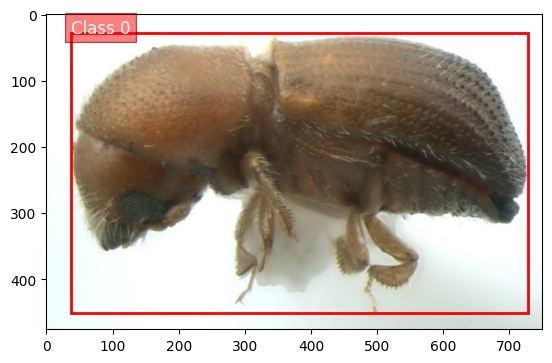

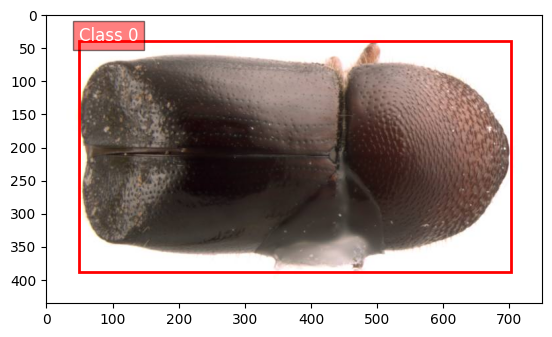

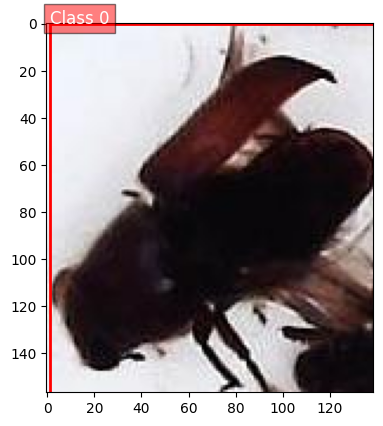

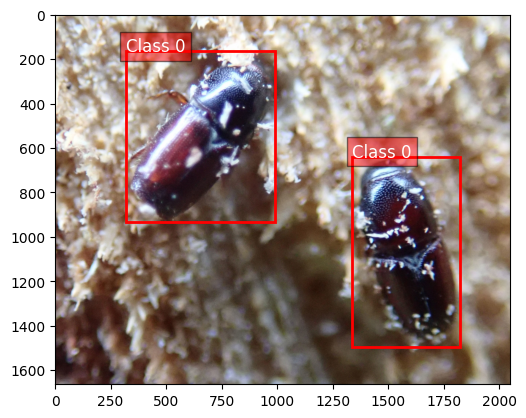

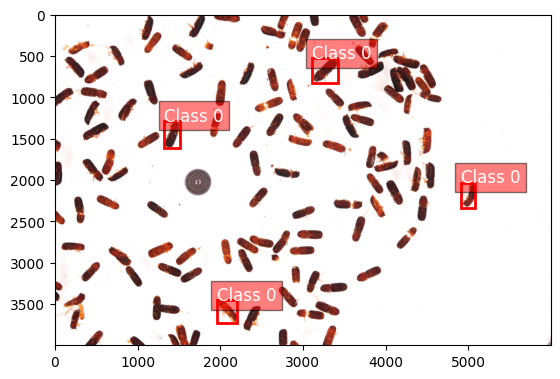

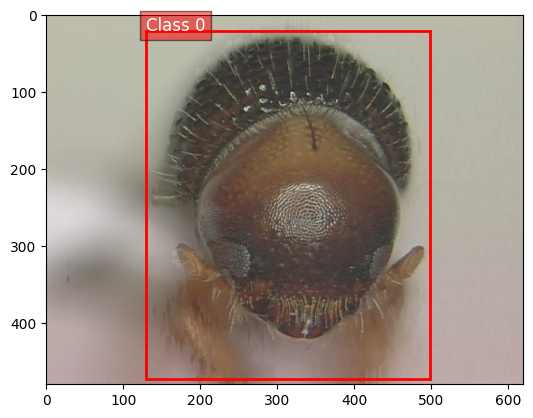

In [29]:
for _ in range(10):
    random_image_path = random.choice(image_paths)
    relative_path = os.path.relpath(random_image_path, dataset_folder)
    annotation_path = os.path.join(annotations_folder, os.path.splitext(relative_path)[0] + ".txt")

    image = Image.open(random_image_path).convert("RGB")
    annotations = load_yolo_annotations(annotation_path)

    draw_bounding_boxes(image, annotations)